# Gemma2-27B Attention Analysis

This notebook analyzes how instruction tuning modifies attention patterns for PC and semantic vectors.

**Key Analyses:**
1. **QK Affinity**: Raw attention logits (before softmax) reveal semantic affinities
2. **VO Decomposition**: What semantic content flows through when attending to a vector
3. **Base vs Instruct Comparison**: How instruction tuning changes routing

**Approach:**
- Compute QK affinity matrices for PC and semantic vectors
- Compute VO decomposition (value-output transformation)
- Analyze z-scores relative to random baseline
- Identify layers and patterns where instruction tuning has strongest effect

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig
from collections import OrderedDict

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_layer_semantic_vectors,
    normalize_vector,
    compute_qk_affinity_matrix,
    compute_vo_decomposition,
    compute_z_score_matrices,
    get_top_interactions,
    analyze_pc_pattern
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Models and Prepare Vectors

In [5]:
# Load models
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
print("✓ Models loaded")

Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [6]:
# Load PC vectors
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"

pca_data, _ = load_pca_data(roles_pca_dir)
pcs, variance_explained = extract_pc_components(pca_data, n_components=3)

# Build test vectors
test_vectors = OrderedDict()
test_vectors['PC1'] = normalize_vector(pcs[0])
test_vectors['PC2'] = normalize_vector(pcs[1])
test_vectors['PC3'] = normalize_vector(pcs[2])
test_vectors['-PC1'] = normalize_vector(-pcs[0].float())

# Add random baseline
torch.manual_seed(42)
for i in range(5):
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    test_vectors[f'Random{i+1}'] = normalize_vector(rand_vec)

vector_names = list(test_vectors.keys())
vectors_tensor = torch.stack([test_vectors[name] for name in vector_names])

print(f"✓ Prepared {len(vector_names)} test vectors")
print(f"  PC vectors: {[n for n in vector_names if 'PC' in n]}")
print(f"  Random vectors: {[n for n in vector_names if 'Random' in n]}")

✓ Prepared 9 test vectors
  PC vectors: ['PC1', 'PC2', 'PC3', '-PC1']
  Random vectors: ['Random1', 'Random2', 'Random3', 'Random4', 'Random5']


/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Compute QK Affinity Matrices

QK affinities reveal which vectors semantically "attend to" each other (before softmax).

In [7]:
# Compute QK affinities for target layers
target_layers = [15, 18, 20, 22, 25]
n_vectors = len(vector_names)

qk_base = np.zeros((len(target_layers), n_vectors, n_vectors))
qk_instruct = np.zeros((len(target_layers), n_vectors, n_vectors))

print(f"Computing QK affinities for layers {target_layers}...")

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(target_layers)):
        qk_b = compute_qk_affinity_matrix(vectors_tensor, layer_idx, base_model)
        qk_i = compute_qk_affinity_matrix(vectors_tensor, layer_idx, instruct_model)
        qk_base[i] = qk_b.cpu().numpy()
        qk_instruct[i] = qk_i.cpu().numpy()

qk_delta = qk_instruct - qk_base
print(f"\n✓ QK affinity computation complete")
print(f"  Shape: {qk_base.shape}")

Computing QK affinities for layers [15, 18, 20, 22, 25]...


100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


✓ QK affinity computation complete
  Shape: (5, 9, 9)


In [8]:
# Compute z-scores relative to random baseline
random_indices = [vector_names.index(n) for n in vector_names if 'Random' in n]
qk_delta_z = compute_z_score_matrices(qk_delta, random_indices)

print(f"✓ Z-score normalization complete")
print(f"\nExample z-scores at layer 18 (index 1):")
if 'PC1' in vector_names:
    pc1_idx = vector_names.index('PC1')
    print(f"  PC1→PC1:  {qk_delta_z[1, pc1_idx, pc1_idx]:.2f}σ")
    print(f"  PC1→-PC1: {qk_delta_z[1, pc1_idx, vector_names.index('-PC1')]:.2f}σ")

✓ Z-score normalization complete

Example z-scores at layer 18 (index 1):
  PC1→PC1:  -1.46σ
  PC1→-PC1: 1.67σ


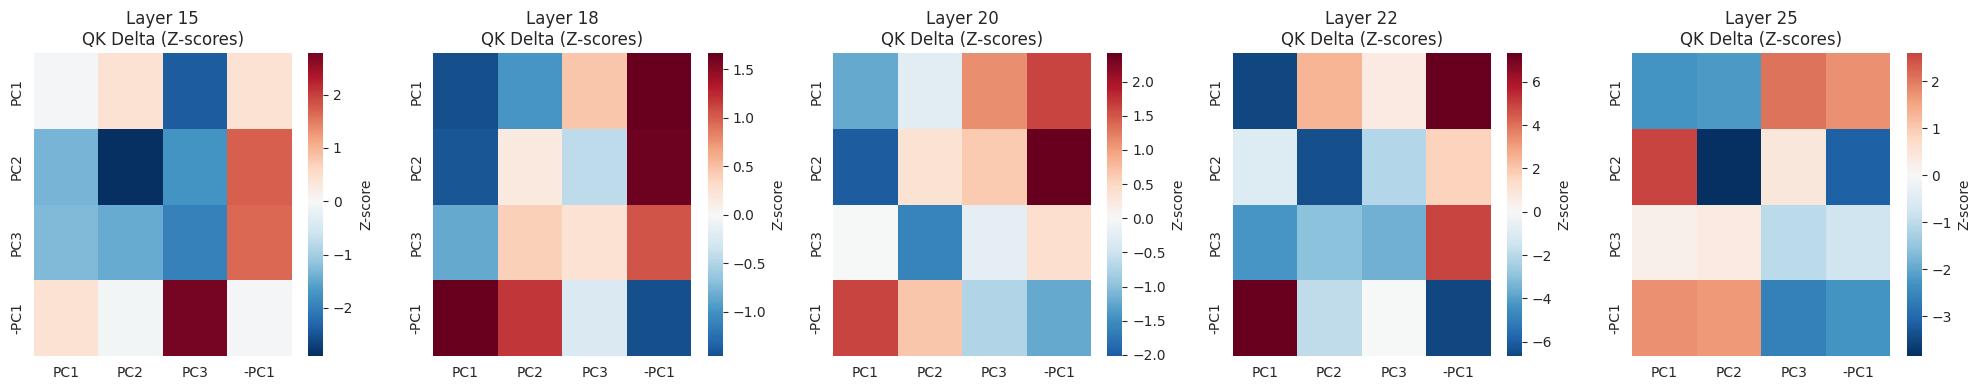

In [9]:
# Visualize QK affinity changes
fig, axes = plt.subplots(1, len(target_layers), figsize=(20, 4))

for i, layer_idx in enumerate(target_layers):
    # Show only PC vectors for clarity
    pc_indices = [vector_names.index(n) for n in vector_names if 'PC' in n]
    pc_names = [vector_names[j] for j in pc_indices]
    
    matrix = qk_delta_z[i][np.ix_(pc_indices, pc_indices)]
    
    sns.heatmap(matrix, ax=axes[i], cmap='RdBu_r', center=0, 
                xticklabels=pc_names, yticklabels=pc_names,
                cbar_kws={'label': 'Z-score'})
    axes[i].set_title(f'Layer {layer_idx}\nQK Delta (Z-scores)')

plt.tight_layout()
plt.show()

## 3. Compute VO Decomposition

VO decomposition reveals what semantic content flows through when attending to a vector.

In [10]:
# Compute VO decomposition
vo_base = np.zeros((len(target_layers), n_vectors, n_vectors))
vo_instruct = np.zeros((len(target_layers), n_vectors, n_vectors))

print(f"Computing VO decomposition for layers {target_layers}...")

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(target_layers)):
        vo_b = compute_vo_decomposition(vectors_tensor, vectors_tensor, layer_idx, base_model)
        vo_i = compute_vo_decomposition(vectors_tensor, vectors_tensor, layer_idx, instruct_model)
        vo_base[i] = vo_b.cpu().numpy()
        vo_instruct[i] = vo_i.cpu().numpy()

vo_delta = vo_instruct - vo_base
vo_delta_z = compute_z_score_matrices(vo_delta, random_indices)

print(f"\n✓ VO decomposition complete")
print(f"  Shape: {vo_base.shape}")

Computing VO decomposition for layers [15, 18, 20, 22, 25]...


100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


✓ VO decomposition complete
  Shape: (5, 9, 9)


In [11]:
# Analyze top VO patterns
print("\n" + "="*80)
print("TOP VO DECOMPOSITION CHANGES (Layer 18)")
print("="*80)

layer_18_idx = target_layers.index(18)
top_vo = get_top_interactions(vo_delta_z, vector_names, layer_18_idx, top_k=10, exclude_self=True)
print("\nTop 10 VO changes (what semantic content flows when attending):")
print(top_vo.to_string(index=False))


TOP VO DECOMPOSITION CHANGES (Layer 18)

Top 10 VO changes (what semantic content flows when attending):
 rank   query     key    value
    1     PC1 Random4 3.331576
    2 Random5     PC1 2.309726
    3     PC2 Random4 2.200383
    4     PC3 Random4 2.111758
    5     PC3    -PC1 1.633686
    6 Random2 Random5 1.581941
    7     PC1 Random5 1.579306
    8 Random3     PC1 1.545293
    9     PC1 Random3 1.482249
   10 Random3     PC2 1.391306


## 4. PC1-Specific Analysis

Focus on how PC1 attention patterns change with instruction tuning.

In [12]:
# Analyze PC1 patterns across layers
if 'PC1' in vector_names:
    pc1_qk = analyze_pc_pattern(qk_delta_z, vector_names, 'PC1', layer_18_idx, top_k=10)
    pc1_vo = analyze_pc_pattern(vo_delta_z, vector_names, 'PC1', layer_18_idx, top_k=10)
    
    print("\n" + "="*80)
    print("PC1 ATTENTION PATTERNS (Layer 18)")
    print("="*80)
    
    print("\nQK Affinity (what PC1 attends to):")
    print(pc1_qk.to_string(index=False))
    
    print("\nVO Decomposition (what flows through when attending to PC1):")
    print(pc1_vo.to_string(index=False))


PC1 ATTENTION PATTERNS (Layer 18)

QK Affinity (what PC1 attends to):
 rank  target     value
    1 Random2  2.019791
    2    -PC1  1.667088
    3 Random3  0.587836
    4     PC3  0.463963
    5 Random1  0.326047
    6 Random4 -0.410858
    7     PC2 -0.971934
    8 Random5 -1.441867
    9     PC1 -1.460641

VO Decomposition (what flows through when attending to PC1):
 rank  target     value
    1     PC1  4.823475
    2 Random4  3.331576
    3 Random5  1.579306
    4 Random3  1.482249
    5     PC3 -0.143363
    6     PC2 -0.306700
    7 Random2 -0.948364
    8 Random1 -0.963228
    9    -PC1 -4.554059


## 5. Summary

This analysis reveals how instruction tuning modifies attention routing for PC and semantic vectors. Key findings:

- **QK Affinity**: Shows which vectors semantically attend to each other
- **VO Decomposition**: Reveals semantic content flow through attention
- **Layer-specific effects**: Different layers show different attention modification patterns
- **PC1 patterns**: PC1 shows distinctive attention changes, particularly at layer 18

These complement the MLP analysis by revealing how semantic information is **routed** (attention) vs **transformed** (MLP).